In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Wed Aug  9 02:46:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   34C    P0    65W / 300W |   2649MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [3]:
n_mels = 768
n_outputs = 61
n_frames = 400

### Model

In [4]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256, dilation_rate=3)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [5]:
save_dir = '/data/scpark/save/lips/train08.09-3/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 21007, model, None, optimizer)

total 645612
-rw-rw-r-- 1 scpark scpark       131  8월  9 02:44 events.out.tfevents.1691516561.GPUSVR11
-rw-rw-r-- 1 scpark scpark 661095663  8월  9 02:44 save_0


### Dataset

In [6]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [7]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=16, shuffle=True, batch_size=32, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [8]:
import fairseq
from torchaudio.transforms import Resample

resample = Resample(24000, 16000)

ckpt_path = "/Storage/speech/pretrained/contentvec/checkpoint_best_legacy_500.pt"
hubert, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
hubert = hubert[0]
hubert = hubert.to(device)
hubert.eval()

def get_hubert_feature(wav):
    with torch.no_grad():
        # (b, t, c)
        wav = resample(torch.Tensor(wav)).to(device)
        feature = hubert.extract_features(wav, output_layer=12)[0]
        return feature.transpose(1, 2)
print('done')

2023-08-09 02:48:02 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/scpark/projects/wav2face
2023-08-09 02:48:02 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2023-08-09 02:48:02 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0.1,

done


test : 0 1.1120526790618896
test : 1 1.1330393552780151
test : 2 1.1186805963516235
test : 3 1.1297953128814697
test : 4 1.116856336593628
test : 5 1.1209461688995361
test : 6 1.1244853734970093
test : 7 1.122375726699829
test : 8 1.1341075897216797
test : 9 1.119718074798584
test_loss : 1.1232057809829712


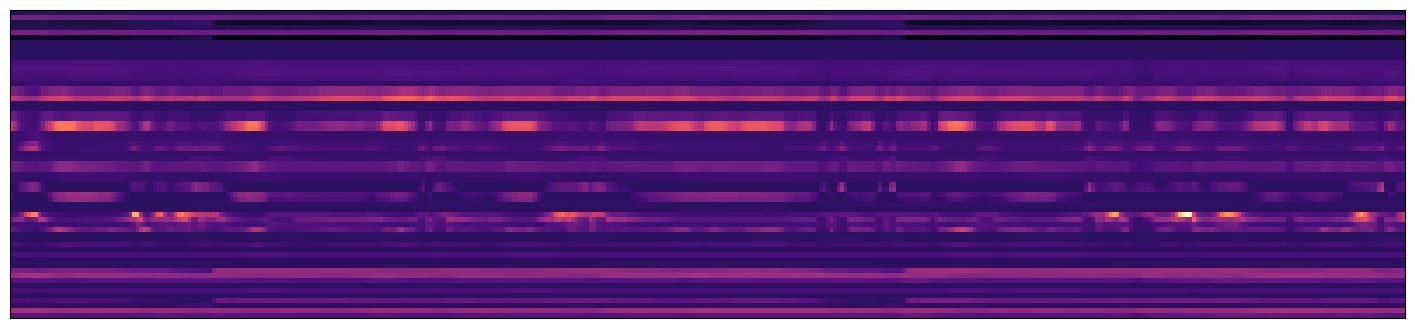

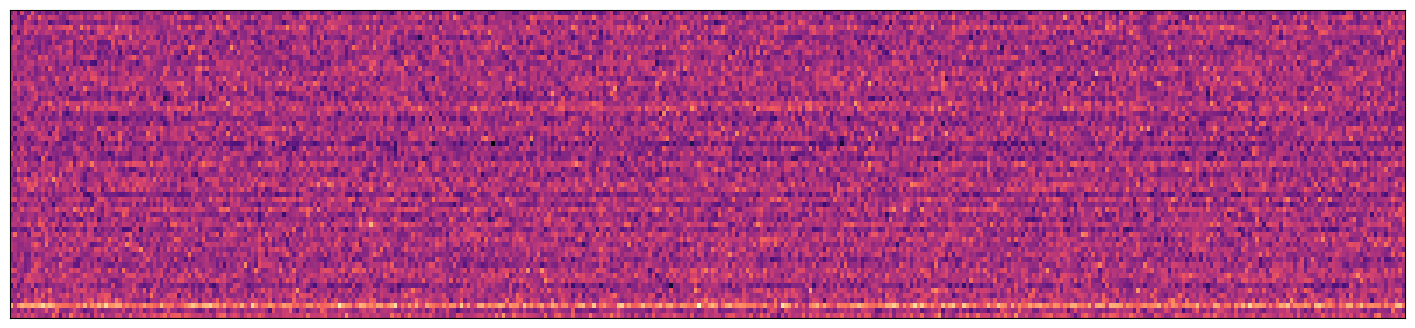

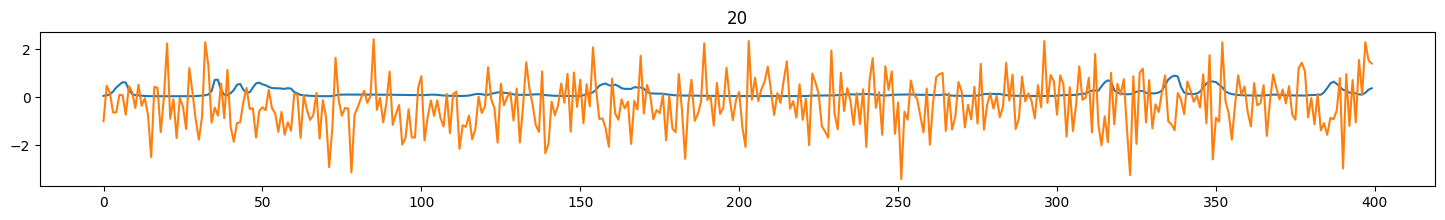

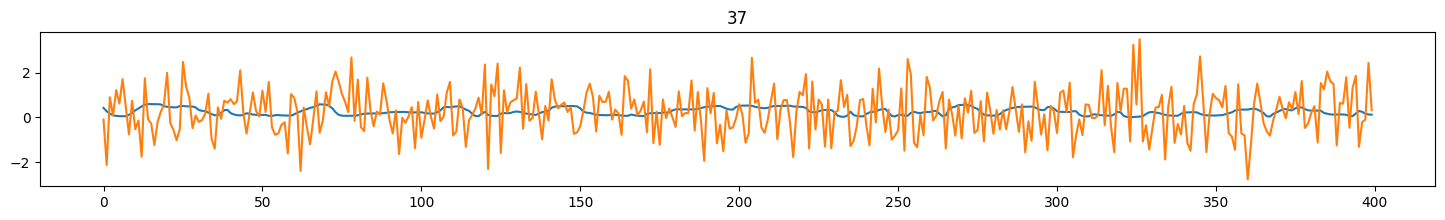

saved /data/scpark/save/lips/train08.09-3/save_0
loss 1.1538426876068115
1 1.1538426876068115
loss 0.8893862366676331
2 0.8893862366676331
loss 0.6855552792549133
3 0.6855552792549133
loss 0.5152691602706909
4 0.5152691602706909
loss 0.35963380336761475
5 0.35963380336761475
loss 0.18099278211593628
6 0.18099278211593628
loss 0.04950207471847534
7 0.04950207471847534
loss -0.08783674240112305
8 -0.08783674240112305
loss -0.21708858013153076
9 -0.21708858013153076
loss -0.33665454387664795
10 -0.33665454387664795
loss -0.40502023696899414
11 -0.40502023696899414
loss -0.6124465465545654
12 -0.6124465465545654
loss -0.6481434106826782
13 -0.6481434106826782
loss -0.8494443893432617
14 -0.8494443893432617
loss -0.9965711832046509
15 -0.9965711832046509
loss -0.9266407489776611
16 -0.9266407489776611
loss -1.0370103120803833
17 -1.0370103120803833
loss -1.1814085245132446
18 -1.1814085245132446
loss -1.1907511949539185
19 -1.1907511949539185
loss -1.1856821775436401
20 -1.1856821775436401


In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        inputs = get_hubert_feature(batch['wav'])
        inputs = F.interpolate(inputs, size=(targets.shape[2]), mode='linear')
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                inputs = get_hubert_feature(batch['wav'])
                inputs = F.interpolate(inputs, size=(targets.shape[2]), mode='linear')
                sid = torch.Tensor(batch['sid']).int().to(device)
                
                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs, sid)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 5000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)

In [ ]:
for i, batch in enumerate(test_loader):
    targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
    inputs = get_hubert_feature(batch['wav'])
    inputs = F.interpolate(inputs, size=(targets.shape[2]), mode='linear')
    sid = torch.Tensor(batch['sid']).int().to(device)
    break

In [ ]:

plt.figure(figsize=[18, 4])
librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
plt.colorbar()
plt.show()

model.eval()
with torch.no_grad():
    y_pred = model.inference(inputs, sid, temperature=0.0)

plt.figure(figsize=[18, 4])
librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
plt.colorbar()
plt.show()

for i in [20, 37]:
    plt.figure(figsize=[18, 2])
    plt.title(str(i))
    plt.plot(targets[0].data.cpu().numpy()[i])
    plt.plot(y_pred[0].data.cpu().numpy()[i])
    plt.show()